# Lock-acquisition sequence example

This example shows how to use the lockbox module to perform a reproducible lock-acquisition sequence with a Fabry Perot cavity thanks to two error signals (reflection and Pound Drever Hall).

In [1]:
# Set environment variable to use a custom configuration file location
import os
os.environ["PYRPL_USER_DIR"] = "../pyrpl_user_dir/"

In [2]:
from pyrpl import Pyrpl, logger, logging
logging.disable(logging.WARNING) # Make the program less verbose
p = Pyrpl("lock_sequence_example")

## Configure lockbox parameters of the physical model

In [3]:
p.lockbox.classname = "HighFinesseFabryPerot" # This instantiates a new Lockbox object with the right class
lockbox = p.lockbox

# parameters of the physical model
lockbox.eta = 0.9 # mode matching
lockbox.wavelength = 1064e-9
lockbox.finesse = 8000
lockbox.round_trip_length = 0.09

## Configure inputs

In [4]:
ref = lockbox.inputs.reflection
ref.input = 'in1'

pdh = lockbox.inputs.pdh
# The IQ module is configured by the lockbox (see example2_pdh_generation for details)
pdh.mod_amp = 1.
pdh.mod_freq = 50e6
pdh.quadrature_factor = 40
pdh.bandwidth = [3e6, 3e6] # second-order lowpass filter
pdh.mod_phase = 35
pdh.mod_output = 'out2'

The inputs panel of the lockbox module should look like the following: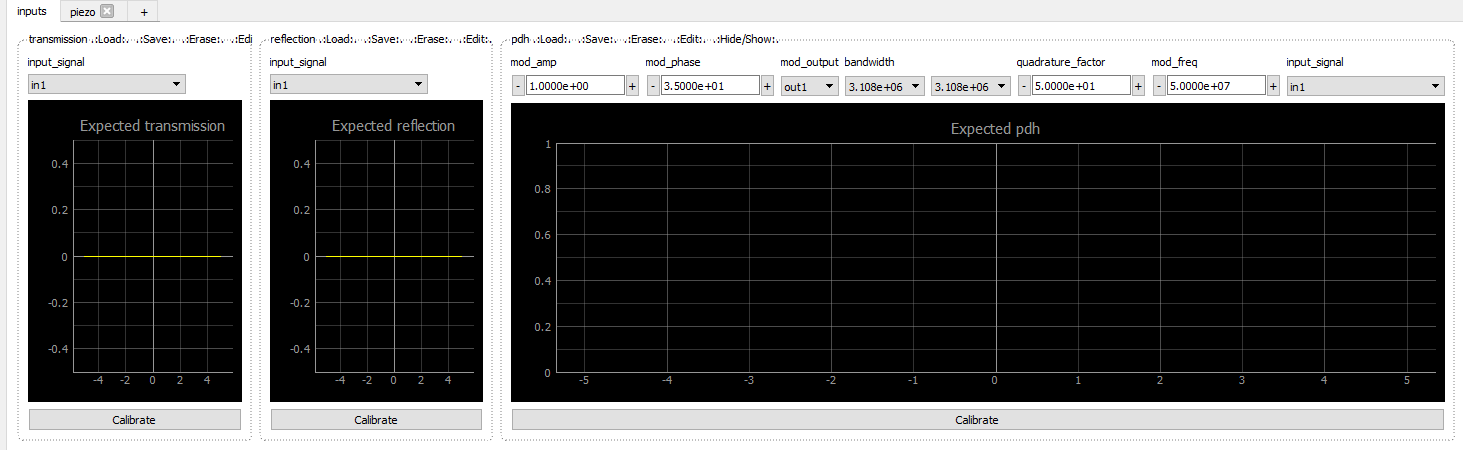

## Configure output

In [5]:
piezo = lockbox.outputs.piezo
piezo.sweep_amplitude = 1.
piezo.sweep_frequency = 5.
piezo.sweep_waveform = "ramp"
piezo.output_channel = 'out1'

piezo.assisted_design = False
piezo.dc_gain = 180e-9 # in m/V

piezo.p = 80 # open-loop proportional gain
piezo.i = 1.6e6 # open-loop integral unity-gain frequency (if plant gain was a constant = analog_dc_gain)

Output piezo panel should look like the following: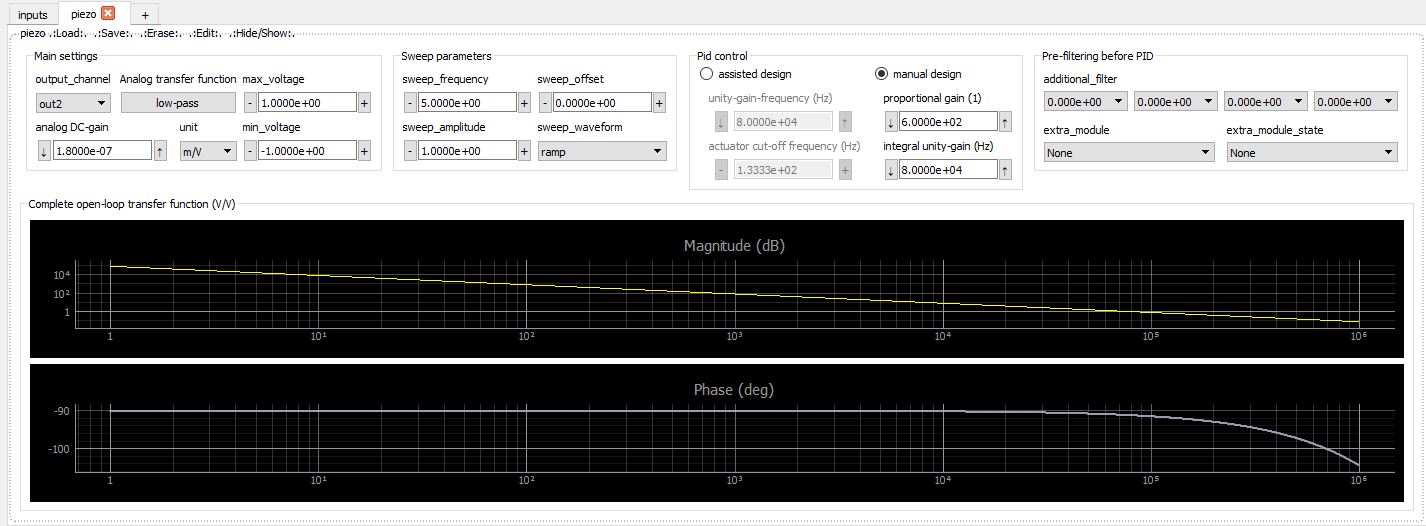

## Monitor error signals

In [6]:
p.lockbox.sweep() # activate the lockbox sweep

# Let's save 2 different states for future use (see example2_pdh_generation for details)
# The automatic input signal calibration of the HighFinesseFabryPerot requires the scope state autosweep_zoom 
## autosweep for full ramp visualization
scope = p.rp.scope
scope.duration = 0.2 #in s
scope.input1 = 'in1'  # Reflection signal from cavity
scope.input2 = 'lockbox.inputs.pdh' # This gets automatically replaced by the right IQ module (iq1 here).
scope.rolling_mode = False # Use actual trigger to synchronize the acquistion

scope.trigger_source = 'asg0'
scope.run_continuous = True    # Acquire data continuously and plot in the scope GUI.

# Let's save the scope state for future use
scope.save_state('autosweep') # state can be loaded with scope.load_state('autosweep')

## autosweep_zoom for full detailed view of the error signals
scope = p.rp.scope
scope.duration = 0.005 #in s (better resolution of the pic)

scope.trigger_source = 'ch1_negative_edge'
scope.threshold = 0.8 # in V
scope.run_continuous = True    # Acquire data continuously and plot in the scope GUI.

# Let's save the scope state for future use
p.rp.scope.save_state('autosweep_pdh')

The scope GUI should look like the following (right-click on the load, save, erase items at the top of the panel to manipulate module states graphically: 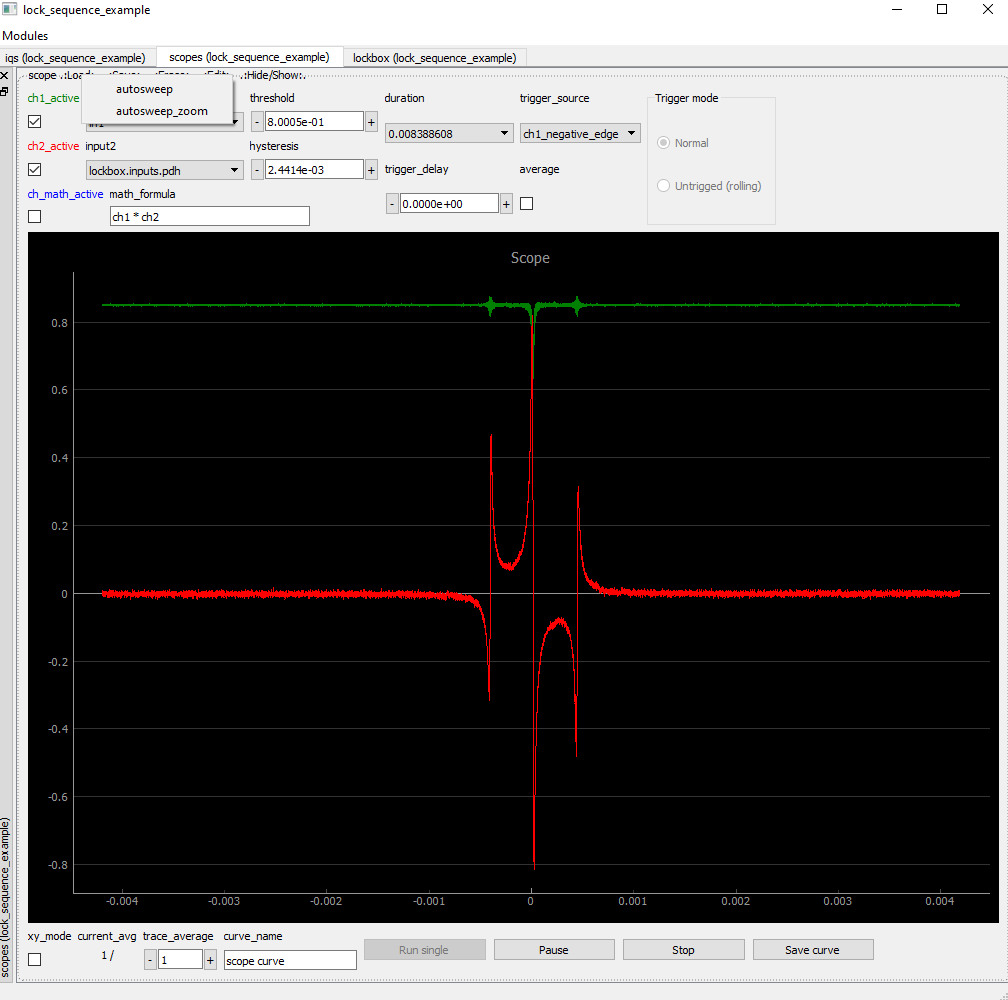

## calibrate inputs 

In [7]:
p.lockbox.calibrate_all()

unsupported operand type(s) for -=: 'NoneType' and 'float'


[]

The error signal amplitude and offsets are now calibrated in Volts: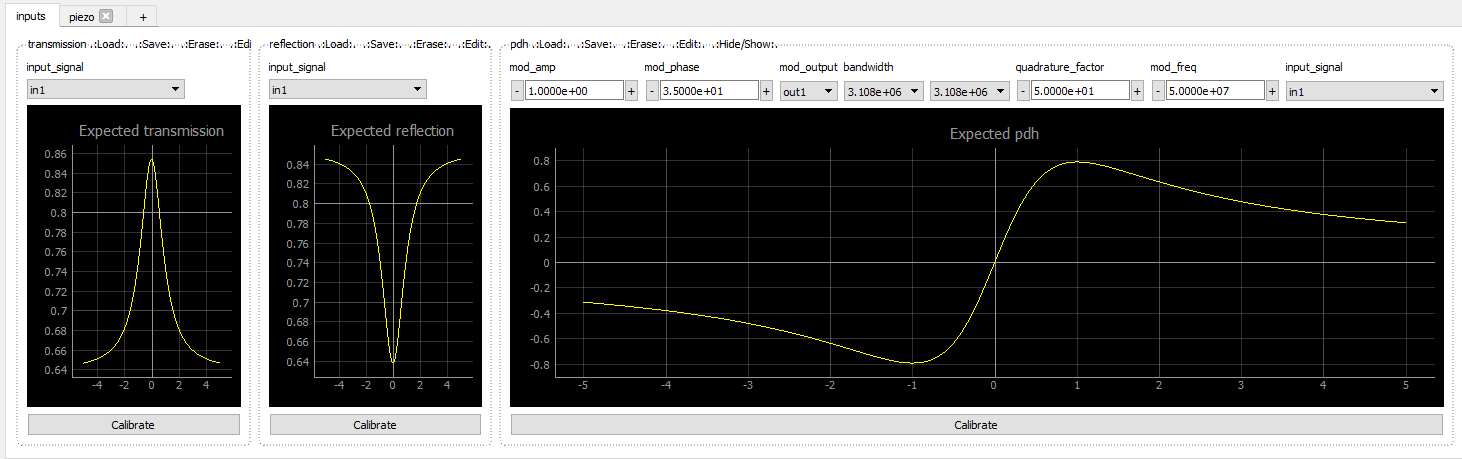

## Configure lock-acquisition sequence

In [8]:
sequence = p.lockbox.sequence

# remove all stages in the sequence (except for the first)
while len(p.lockbox.sequence)>1:
    p.lockbox.sequence.remove(p.lockbox.sequence[-1])

# configure first stage
stage0 = p.lockbox.sequence[0]
stage0.outputs.piezo.lock_on = False # Can be either True, False, or "ignore"
stage0.outputs.piezo.reset_offset = True # reset integrator offset at 1 V
stage0.outputs.piezo.offset = 1.

# Create and configure second stage
sequence.append({})
stage1 = p.lockbox.sequence[1]
stage1.input = 'reflection'
stage1.setpoint = -3. # in units of cavity linewidth
stage1.duration = 0.6 # time before switching to next stage
stage1.gain_factor = 1e-3 # Gain to apply compared to output transfer function
stage1.outputs.piezo.reset_offset = False
stage1.outputs.piezo.lock_on = True

# Create and configure third stage
sequence.append({})
stage2 = p.lockbox.sequence[2]
stage2.input = 'pdh'
stage2.setpoint = 0 # in units of cavity linewidth
stage2.gain_factor = 1. # Gain to apply compared to output transfer function
stage2.outputs.piezo.reset_offset = False
stage2.outputs.piezo.lock_on = True

The lock acquistion sequence panel of the lockbox should look like the following: 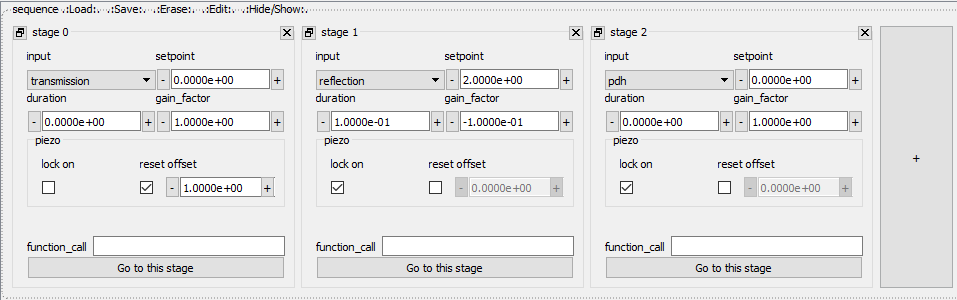

## Check lock acquisition sequence (scope in rolling mode)

In [9]:
## Configure the scope in "rolling mode" (only allowed for duration >0.1s)

p.rp.scope.duration = 8
p.rp.scope.rolling_mode = True
p.rp.scope.input1 = 'in1'
p.rp.scope.input2 = 'out1'
p.rp.scope.save_state('rolling_8s')

p.rp.scope.run_continuous = True

# launch the lock sequence
p.lockbox.lock()

True

In rolling mode, the traces slowly roll from right to left. This is a convenient configuration to monitor non-periodic signals such as lock-acquisition sequences:
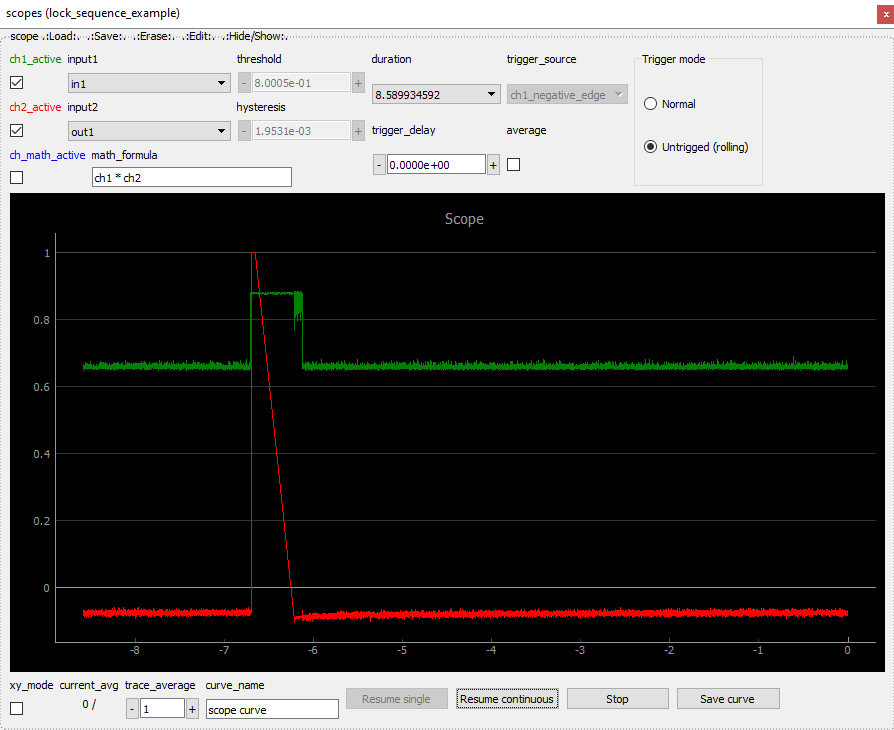

## Acquire data for figure

### Lock acquisition sequence

cancel acquire
cancel acquire


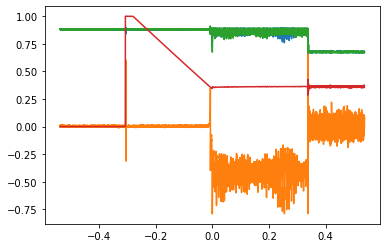

In [10]:
from pyrpl.async_utils import sleep, wait # allows to sleep without freezing the GUI
from pylab import plt, np
scope = p.rp.scope

CHANNELS = [["in1", "iq1"],  # Channels to record
            ["in1", "out1"]] # (2 successive acquisitions are needed since the scope only has 2 channels)
channel_data = np.zeros((len(np.array(CHANNELS).flatten()), 2**14))

scope.duration = 1 # 1 s trace duration
scope.threshold = 0.8   # set threshold slightly above reflection at resonance 
scope.trigger_source = "ch1_negative_edge"
scope.rolling_mode = False
scope.average = False    # don't average out high-frequency noise
times = p.rp.scope.times # x-axis for the plot

for index, (ch1, ch2) in enumerate(CHANNELS): # acquire pairs of channels successively
    scope.input1 = ch1
    scope.input2 = ch2
    p.lockbox.unlock()              # unlock the lockbox
    res = p.rp.scope.single_async() # Launch scope acquisition (scope waiting for trigger)
    sleep(0.5)                      # give some time to acquire pretrig data
    p.lockbox.lock()                # Trig should occur at the end of the lock sequence
    channel_data[2*index:2*index + 2] = wait(res) # wait for trigger and recover scope data

# quick display of acquired data
plt.close('all')
plt.figure()
for ch_data in channel_data:
    plt.plot(times, ch_data.T)

In [11]:
# Save data
import h5py
kwds = dict(times=times, channel_data=channel_data)

with h5py.File("./data/data.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

### Error signals

cancel acquire


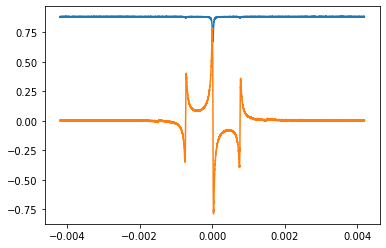

In [12]:
p.rp.scope.load_state("autosweep_pdh") # recall scope state
p.lockbox.sweep()  # sweep piezo actuator 
refl, pdh = p.rp.scope.single() # acquire error signals
times = p.rp.scope.times # x-axis for plot
plt.plot(times, np.array((refl, pdh)).T)

In [13]:
# Save data
kwds = dict(times_sweep=times, refl_sweep=refl, pdh_sweep=pdh)
        
with h5py.File("./data/data_sweep.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

## Load data and plot figure

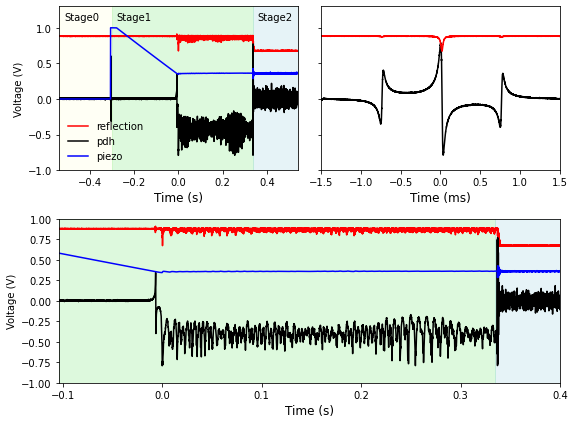

In [26]:
from pylab import np, plt
from matplotlib.patches import Rectangle

import h5py
kwds = {}
with h5py.File("./data/data.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
times = kwds["times"]
channel_data = kwds["channel_data"]
ch1, reflection, ch2 = channel_data[1:]

kwds = {}
with h5py.File("./data/data_sweep.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
times_sweep = kwds["times_sweep"]
refl_sweep = kwds["refl_sweep"]
pdh_sweep = kwds["pdh_sweep"]

fig = plt.figure(figsize=(8,6))
plt.title(r'Locking sequence')

ax_main_sequence = plt.subplot(221)
ax_main_sequence.plot(times, reflection, 'r', label = 'reflection')
ax_main_sequence.plot(times, ch1, 'k', label = 'pdh')
ax_main_sequence.plot(times, ch2, 'b', label = 'piezo')
ax_main_sequence.set_xlabel(r'Time (s)', fontsize=12)
ax_main_sequence.set_ylabel(r'Voltage (V)')
plt.legend(frameon=False)
lims = ax_main_sequence.get_ylim()

ax_sweep = plt.subplot(222, sharey=ax_main_sequence)
ax_sweep.plot(times_sweep*1e3, pdh_sweep, 'k')
ax_sweep.plot(times_sweep*1e3, refl_sweep, 'r')
plt.setp(ax_sweep.get_yticklabels(), visible=False)
ax_sweep.set_xlim(-1.5, 1.5)
ax_sweep.set_ylim(lims)
ax_sweep.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax_sweep.set_xlabel(r'Time (ms)', fontsize=12)
plt.subplots_adjust(wspace=0)


ax_zoom_sequence = plt.subplot(212)
ax_zoom_sequence.plot(times, reflection, 'r', label='reflection')
ax_zoom_sequence.plot(times, ch1, 'k', label = 'pdh')
ax_zoom_sequence.plot(times, ch2, 'b', label = 'piezo')
ax_zoom_sequence.set_xlabel(r'Time (s)', fontsize=12)
ax_zoom_sequence.set_ylabel(r'Voltage (V)')
#plt.legend(frameon=False)
ZOOM_START = -0.104
ZOOM_STOP = 0.4
ax_zoom_sequence.set_xlim(ZOOM_START, ZOOM_STOP)

lims = ax_main_sequence.get_ylim()

TIME_STAGE0 = np.min(times)
TIME_STAGE1 = -0.3
TIME_STAGE2 = 0.335

ax_main_sequence.add_patch(Rectangle((TIME_STAGE0, -1), TIME_STAGE1-TIME_STAGE0, 6, alpha=0.3, color='lightyellow'))
ax_main_sequence.text(TIME_STAGE0 + 0.02, 1.1, "Stage0")


ax_main_sequence.add_patch(Rectangle((TIME_STAGE1, -1), TIME_STAGE2-TIME_STAGE1, 6, alpha=0.3, color='lightgreen'))
ax_main_sequence.text(TIME_STAGE1 + 0.02, 1.1, "Stage1")
ax_zoom_sequence.add_patch(Rectangle((ZOOM_START, -1), TIME_STAGE2-ZOOM_START, 6, alpha=0.3, color='lightgreen'))


ax_main_sequence.add_patch(Rectangle((TIME_STAGE2, -1), 0.6, 6, alpha=0.3, color='lightblue'))
ax_zoom_sequence.add_patch(Rectangle((TIME_STAGE2, -1), ZOOM_STOP, 6, alpha=0.3, color='lightblue'))
ax_zoom_sequence.set_ylim(-1., 1.)
ax_main_sequence.text(TIME_STAGE2+0.02, 1.1, "Stage2")
ax_main_sequence.set_ylim(-1, 1.3)
ax_main_sequence.set_xlim(-0.54, 0.54)

plt.tight_layout()
plt.show()

fig.savefig("./figure_lock_sequence.pdf")